# \[STAT-315\] Bikeshare Insights Data Analysis Project

#### Defining the questions:
We first ask the following questions:
1. Can we predict which casual riders are most likely to benefit from a membership, enabling targeted promotional strategies?
2. Are there any seasonal or temporal patterns in ridership behavior that could be used to optimize station positioning and bike allocations to stations?
3. Which factors (such as membership status, trip length, bike type, day of week, or station location) most strongly influence whether a rider chooses an electric versus a classic bike, and how much do these factors impact overall demand?


#### Data collection

For our given questions, we decide to leverage the Divvy dataset previously used for our mini-project. Simply run the following cell to obtain the bike sharing insights data for the year of 2023. It will be stored in `./data/`.

In [1]:
!python combine.py

Reading all Divvy .csv files.: 100%|████████████| 12/12 [00:10<00:00,  1.13it/s]
Creating concatenated .csv file.
Successfully created merged .csv file. Path is ./data/2023-divvy-tripdata.csv


#### Data cleaning and preparation
We then prepare the data for our analysis by cleaning out unusual rows and adding additional features.

In [152]:
# required imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [4]:
# loading data
divvy_df = pd.read_csv("./data/2023-divvy-tripdata.csv", index_col=0)
divvy_df = divvy_df.reset_index(drop=True)

In [5]:
# get rid of abnormally long or short ride times (<1 minute or >2 hours)
divvy_df["started_at"] = pd.to_datetime(divvy_df["started_at"])
divvy_df["ended_at"] = pd.to_datetime(divvy_df["ended_at"])

divvy_df["ride_duration_min"] = (divvy_df["ended_at"] - divvy_df["started_at"]).astype('int64') / 60_000_000_000

divvy_df = divvy_df[(1 <= divvy_df["ride_duration_min"]) & (divvy_df["ride_duration_min"] <= 120)]

In [6]:
# get rid of abnormally long distances
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

divvy_df["distance_km"] = haversine(
    divvy_df["start_lat"],
    divvy_df["start_lng"],
    divvy_df["end_lat"],
    divvy_df["end_lng"]
)

divvy_df = divvy_df[(divvy_df["distance_km"] <= 15) & (divvy_df["distance_km"] > 0.1)]

In [103]:
# adds time sections and season to dataframe
def season(month: int):
    if month in [1, 2, 12]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

divvy_df["hour"] = divvy_df["started_at"].dt.hour
divvy_df["dayofweek"] = divvy_df["started_at"].dt.day_name()
divvy_df["month"] = divvy_df["started_at"].dt.month
divvy_df["season"] = divvy_df["started_at"].dt.month.apply(season)

In [8]:
# add km/hr to dataset, removing abnormally low values
# they have significantly higher ride times (~1 hr)
divvy_df["avg_velocity_km_per_hr"] = divvy_df["distance_km"] / (divvy_df["ride_duration_min"] / 60)
divvy_df = divvy_df[divvy_df["avg_velocity_km_per_hr"] > 2]

In [17]:
# ensure no null values in dataframe
divvy_df = divvy_df.dropna()
divvy_df.isna().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
ride_duration_min         0
distance_km               0
season                    0
avg_velocity_km_per_hr    0
dtype: int64

In [37]:
# get both start and end stations with non-matching names and ids
# e.g. one station is mapped to two ids on either start or end
stations = pd.concat([divvy_df[["start_station_name", "start_station_id"]].rename(columns={"start_station_name": "station_name", "start_station_id": "station_id"}),
                      divvy_df[["end_station_name", "end_station_id"]].rename(columns={"end_station_name": "station_name", "end_station_id": "station_id"})],
                      ignore_index=True)

name_to_id = (
    stations.groupby("station_name")["station_id"]
      .agg(lambda x: x.value_counts().idxmax())
)

mismatched_start_stations = divvy_df["start_station_id"] != divvy_df["start_station_name"].map(name_to_id)
mismatched_end_stations = divvy_df["end_station_id"] != divvy_df["end_station_name"].map(name_to_id)

suspicious_stations = pd.concat([divvy_df[mismatched_start_stations]["start_station_name"].drop_duplicates(), divvy_df[mismatched_end_stations]["end_station_name"].drop_duplicates()])
divvy_df = divvy_df[~divvy_df["start_station_name"].isin(suspicious_stations) & ~divvy_df["end_station_name"].isin(suspicious_stations)]

In [41]:
divvy_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_min,distance_km,season,avg_velocity_km_per_hr
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member,10.850000,0.839042,winter,4.639863
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.483333,1.204573,winter,8.519576
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual,13.233333,3.543683,winter,16.067074
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,8.766667,1.204573,winter,8.244229
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,15.316667,1.204573,winter,4.718677


In [42]:
divvy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3913034 entries, 0 to 5719876
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   ride_id                 object        
 1   rideable_type           object        
 2   started_at              datetime64[ns]
 3   ended_at                datetime64[ns]
 4   start_station_name      object        
 5   start_station_id        object        
 6   end_station_name        object        
 7   end_station_id          object        
 8   start_lat               float64       
 9   start_lng               float64       
 10  end_lat                 float64       
 11  end_lng                 float64       
 12  member_casual           object        
 13  ride_duration_min       float64       
 14  distance_km             float64       
 15  season                  object        
 16  avg_velocity_km_per_hr  float64       
dtypes: datetime64[ns](2), float64(7), object(8)
memory 

#### Data Analysis
Q2: Are there any seasonal or temporal patterns in ridership behavior that could be used to optimize station positioning and bike allocations to stations?

Analysis #1: Monthly and Seasonal Ridership Volume

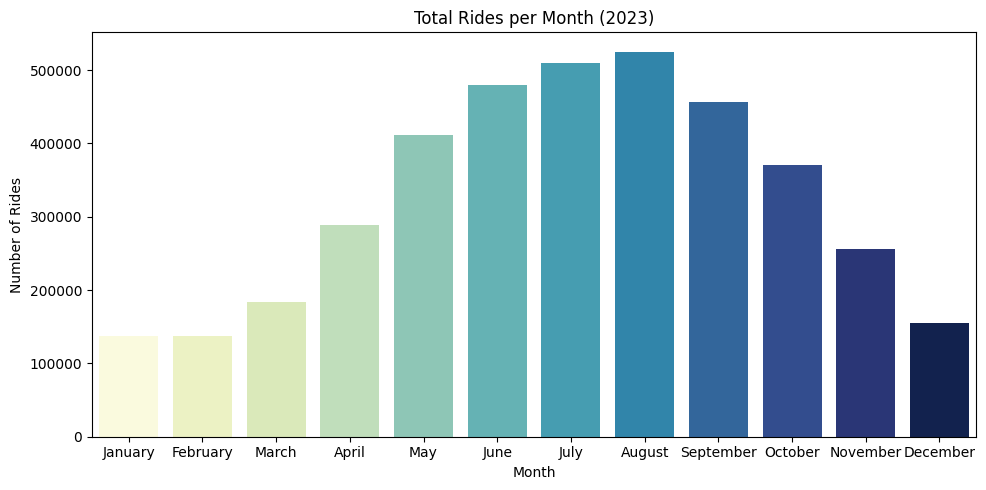

In [90]:
# total number of rides per month
month_map = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
monthly_counts = divvy_df.groupby("month").size().reset_index(name="ride_count")

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_counts, x=month_map, y="ride_count", hue="month", palette="YlGnBu", legend=None)
plt.title("Total Rides per Month (2023)")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.tight_layout()
plt.show()

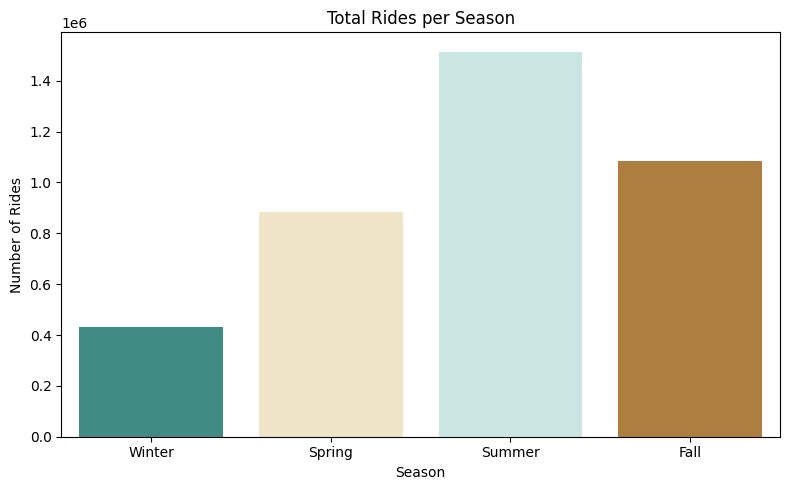

In [181]:
# total number of riders by season
season_order = ["Winter", "Spring", "Summer", "Fall"]
seasonal_counts = (
    divvy_df
    .groupby("season")
    .size()
    .reset_index(name="ride_count")
)

plt.figure(figsize=(8, 5))
sns.barplot(data=seasonal_counts, x="season", y="ride_count", order=season_order, hue="season", palette="BrBG")
plt.title("Total Rides per Season")
plt.xlabel("Season")
plt.ylabel("Number of Rides")
plt.tight_layout()
plt.show()

Analysis #2: Hourly and Daily Ridership Volume

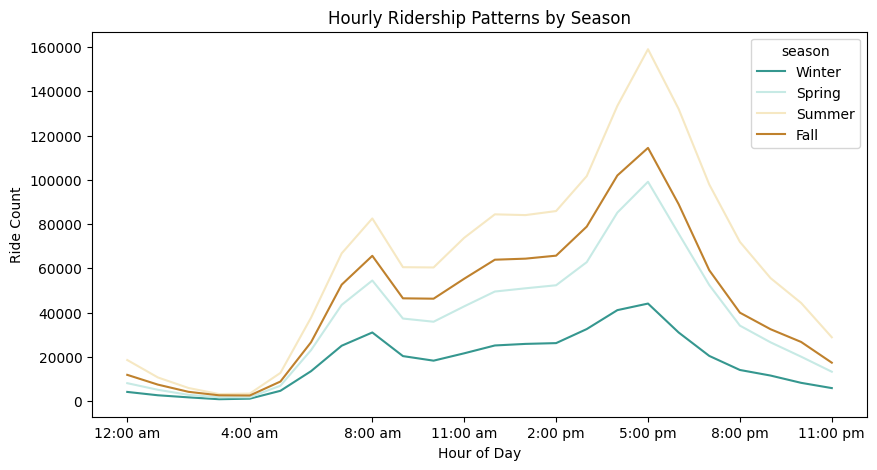

In [108]:
hour_season_counts = (
    divvy_df
    .groupby(["season", "hour"])
    .size()
    .reset_index(name="ride_count")
)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=hour_season_counts,
    x="hour",
    y="ride_count",
    hue="season",
    hue_order=season_order,
    palette="BrBG_r"
)
ax.set_xticks([0, 4, 8, 11, 14, 17, 20, 23])
ax.set_xticklabels(["12:00 am","4:00 am","8:00 am","11:00 am","2:00 pm","5:00 pm","8:00 pm","11:00 pm"])

plt.title("Hourly Ridership Patterns by Season")
plt.xlabel("Hour of Day")
plt.ylabel("Ride Count")
plt.tight_layout()
plt.show()

/var/folders/l1/2tgm91px2_q9xd4n6lp4bbw40000gp/T/ipykernel_75191/1131412543.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["season", "dayofweek"])


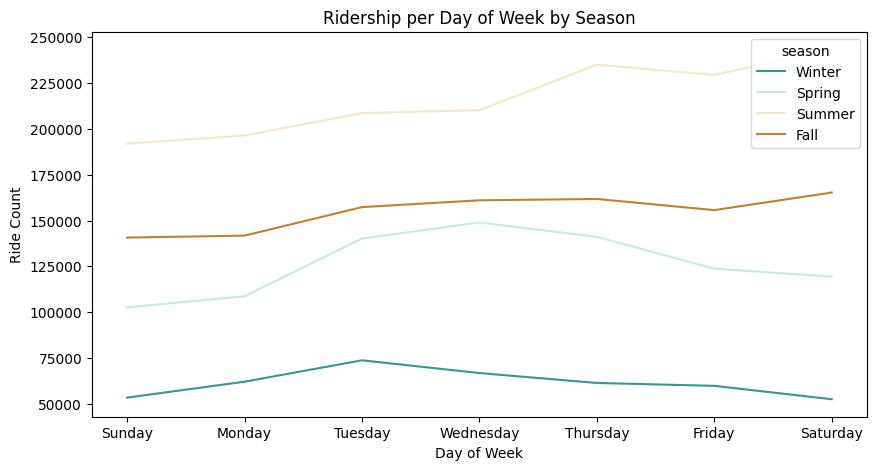

In [126]:
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

daily_counts = (
    divvy_df
    .groupby(["season", "dayofweek"])
    .size()
    .reset_index(name="ride_count")
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=daily_counts,
    x="dayofweek",
    y="ride_count",
    hue="season",
    hue_order=season_order,
    palette="BrBG_r"
)
plt.title("Ridership per Day of Week by Season")
plt.xlabel("Day of Week")
plt.ylabel("Ride Count")
plt.tight_layout()
plt.show()

Analysis #3: Station Statistics by Season

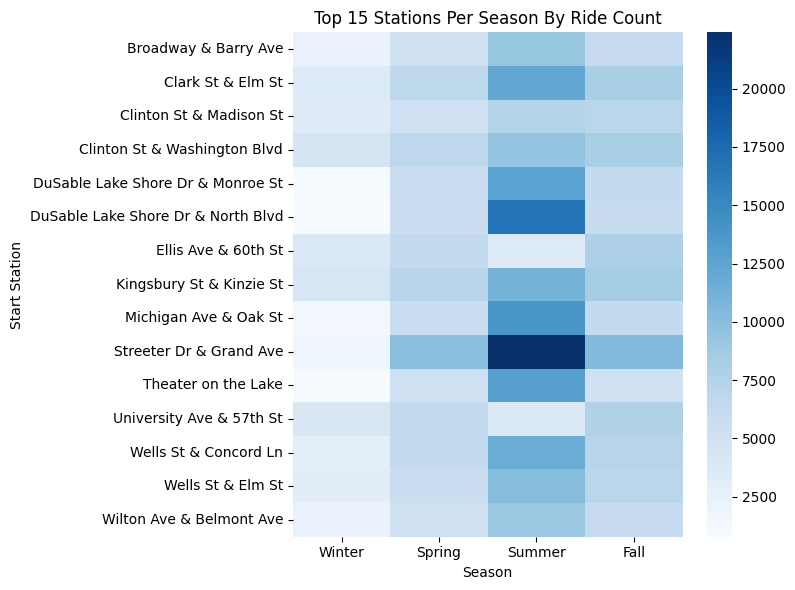

In [193]:
station_season_counts = (
    divvy_df
    .groupby(["season", "start_station_name"])
    .size()
    .reset_index(name="ride_count")
)

overall_top = (
    station_season_counts
    .groupby("start_station_name")["ride_count"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)

top_matrix = (
    station_season_counts[
        station_season_counts["start_station_name"].isin(overall_top)
    ]
    .pivot(index="start_station_name", columns="season", values="ride_count")
    .reindex(columns=season_order)
    .fillna(0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    top_matrix,
    annot=False,
    cmap="Blues"
)
plt.title("Top 15 Stations Per Season By Ride Count")
plt.xlabel("Season")
plt.ylabel("Start Station")
plt.tight_layout()
plt.show()


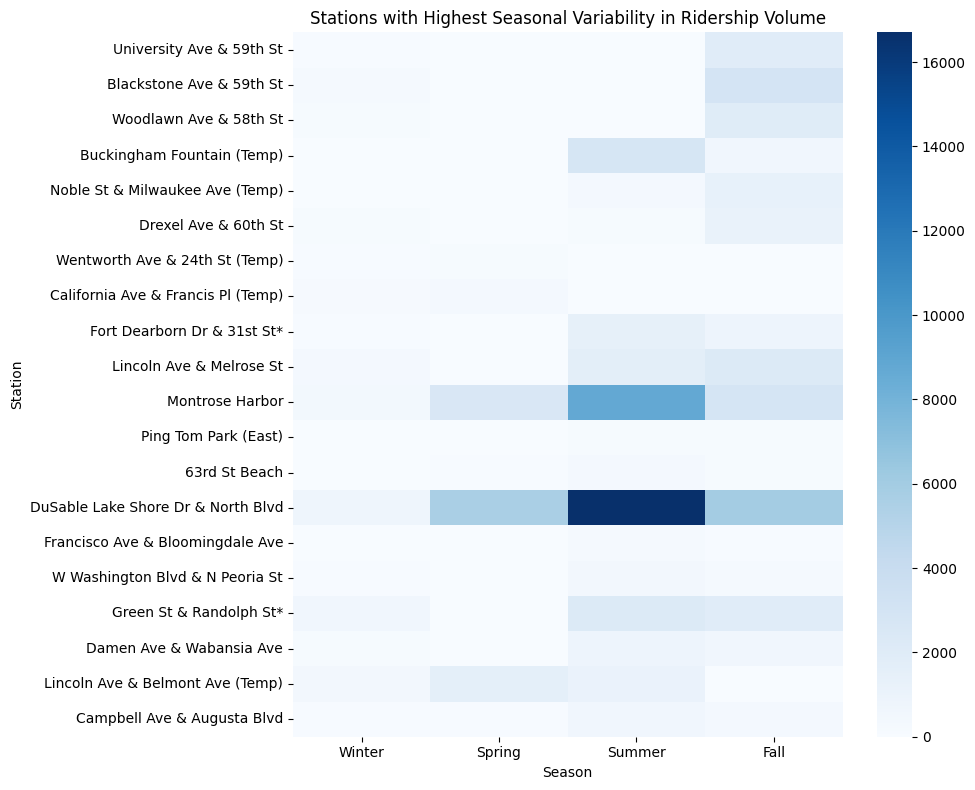

In [192]:
station_matrix = station_season_counts.pivot(
    index="start_station_name",
    columns="season",
    values="ride_count"
).fillna(0)

station_matrix["mean"] = station_matrix.mean(axis=1)
station_matrix["std"] = station_matrix.std(axis=1)
station_matrix["cv"] = station_matrix["std"] / station_matrix["mean"]
station_matrix_filtered = station_matrix[station_matrix["mean"] > 50]

top_var = station_matrix_filtered.sort_values("cv", ascending=False).head(20)
top_var[season_order + ["cv"]]

plt.figure(figsize=(10, 8))
sns.heatmap(
    top_var[season_order],
    cmap="Blues",
    annot=False
)
plt.title("Stations with Highest Seasonal Variability in Ridership Volume")
plt.xlabel("Season")
plt.ylabel("Station")
plt.tight_layout()
plt.show()

Analysis #4: R

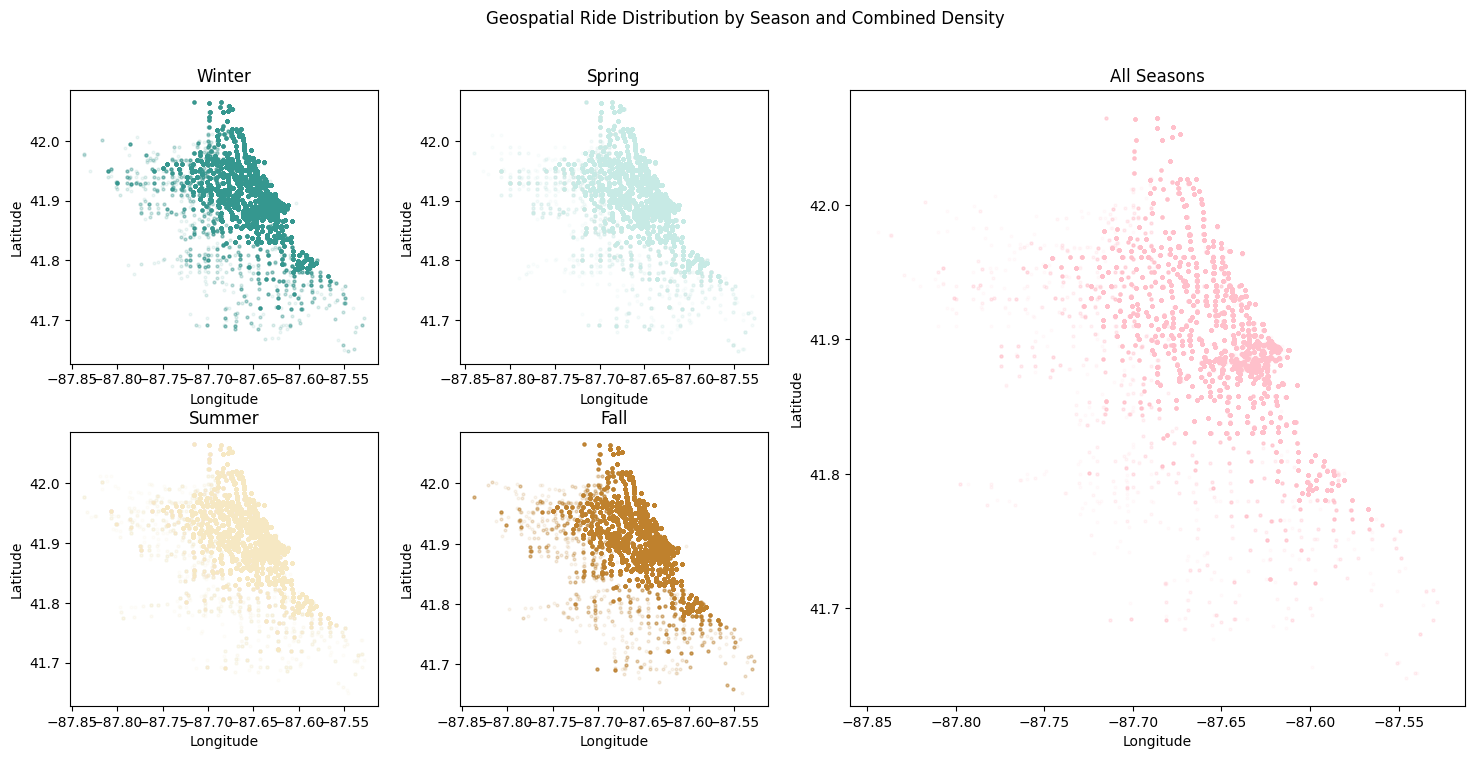

In [ ]:
import matplotlib.gridspec as gridspec

palette = sns.color_palette("BrBG_r", n_colors=4)
season_to_color = dict(zip(season_order, palette))

fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,2], wspace=0.2, hspace=0.25)

ax_winter = fig.add_subplot(gs[0, 0])
ax_spring = fig.add_subplot(gs[0, 1])
ax_summer = fig.add_subplot(gs[1, 0])
ax_fall   = fig.add_subplot(gs[1, 1])

axes_season = {
    "Winter": ax_winter,
    "Spring": ax_spring,
    "Summer": ax_summer,
    "Fall": ax_fall
}

for season in season_order:
    ax = axes_season[season]
    df_s = divvy_df[divvy_df["season"] == season]

    xs = pd.concat([df_s["start_lng"], df_s["end_lng"]])
    ys = pd.concat([df_s["start_lat"], df_s["end_lat"]])

    idx = np.random.choice(xs.index, min(120000, len(xs)), replace=False)

    ax.scatter(xs.loc[idx], ys.loc[idx],
               s=4, alpha=0.08, color=season_to_color[season])
    ax.set_title(season)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

ax_total = fig.add_subplot(gs[:, 2])

xs_all = pd.concat([divvy_df["start_lng"], divvy_df["end_lng"]])
ys_all = pd.concat([divvy_df["start_lat"], divvy_df["end_lat"]])

idx_all = np.random.choice(xs_all.index, min(120000, len(xs_all)), replace=False)

ax_total.scatter(xs_all.loc[idx_all], ys_all.loc[idx_all],
                 s=4, alpha=0.06, color="pink")
ax_total.set_title("All Seasons")
ax_total.set_xlabel("Longitude")
ax_total.set_ylabel("Latitude")

plt.suptitle("Geospatial Ride Distribution by Season and Combined Density")
plt.show()
